# Least-Squares Background Fitting
We attempt to fit a range of polynomial functions to the background using a linear least-squares fitting routine as implemented by SciPy. This is a binned fitting routine. Optimised parameters are retained in this notebook and in the more general data directory.

In [19]:
!pip install --user lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84401 sha256=e4dc738faed5d2b6c159fadc6e6f5eb924b35f3cf9e2b4372d3548f2d20ecdec
  Stored in directory: /disk/homedisk/home/user211/.cache/pip/wheels/76/f4/32/c336957bfd694c7746f4df19b74e08d918ada688fe1349cca2
  Created wheel for asteval: filename=asteval-0.9.26-py3-none-any.whl size=17648 sha256=c9092a22fd4e727bb47eb6fcf24fef031ff0051dcf3a53ab566f53fb61ce96fb
  Stored in directory: /disk/homedisk/home/user211/.cache/pip/wheels/2f/e1/8d/9c9d29d91b8e6e79c0de5d06a09b5e69b0e4e390fa9765a449
Successfully built lmfit asteval


In [6]:
import numpy as np
import uproot as up
from scipy.optimize import curve_fit
import pandas
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [7]:
NBINS = 100
low_mass_limit = 4500
high_mass_limit = 6500

## Fetch Mass Distribution
We need to construct an actual background mass distribution to fit from. We will use the background data as given in the real tuple and restrict the sidebands to the values the neural network is currently using. We will also want to try the optimisation using a variety of bin widths.

In [8]:
fname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"

with up.open(fname + ":DTT1520me/DecayTree") as f:
    df = f.arrays(['Lb_M'], library='pd')
    df = df.sample(frac=1, random_state=0)
    df = df[~df.index.duplicated(keep='first')]

## Bin the Distribution
Now that we have a dataframe with all the background events we care about it is now prudent to fit our background functions to this. Before doing this these data should be put into bins. The value of bins is variable and will affect the final fit. For this reason we choose the finest bin structure possible.

In [9]:
bins = np.linspace(low_mass_limit, high_mass_limit, NBINS + 1)
bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]
# Calculate a bin distribution first

df = df[df['Lb_M'].between(low_mass_limit, high_mass_limit)]
# Apply the mass range restriction

f, _ = np.histogram(df['Lb_M'], bins=bins)
# Generate a histogram using said bin structre
err = np.sqrt(f)
# Assume Poisson statistics so that the errors are proportional to the count

d = np.array([bin_centres, f, err]).T
# Combine all the useful data into a large array

In [10]:
d = d[(d[:,1] != 0)]
# Remove all the rows with zero count in the blinded region

## Visual Analysis
The best way to get a feel for these data is to do an initial visual analysis. We can do this by plotting the mass distribution and seeing what sort of shape it seems to take. We might normally expect a combinatorial background to be exponentially decaying excluding any resonances.

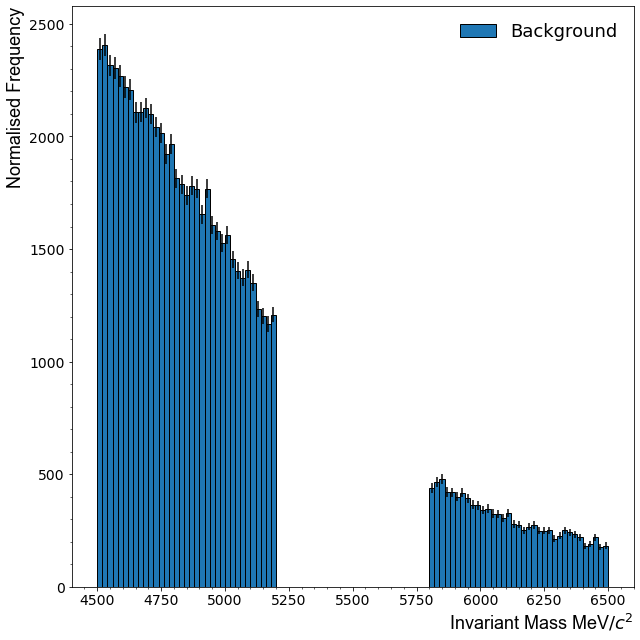

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Background', edgecolor='k')

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
#plt.savefig('../images/BackgroundFits/BgMassDistribution_PresentReady.png', dpi=800)
plt.show()

## Fitting Polynomials

In [12]:
def quadratic(x, N, A, b, c):
    return N*(A*(x**2) + (b*x) + c)

popt, pcov = curve_fit(quadratic, d[:,0], d[:,1], [1e-2, 1e-3, -5, 5e4], d[:,2], absolute_sigma=True)
# Do the optimisation

func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
print(popt)

[ 2.51176390e-01  2.19778318e-03 -2.87452426e+01  9.47700833e+04]


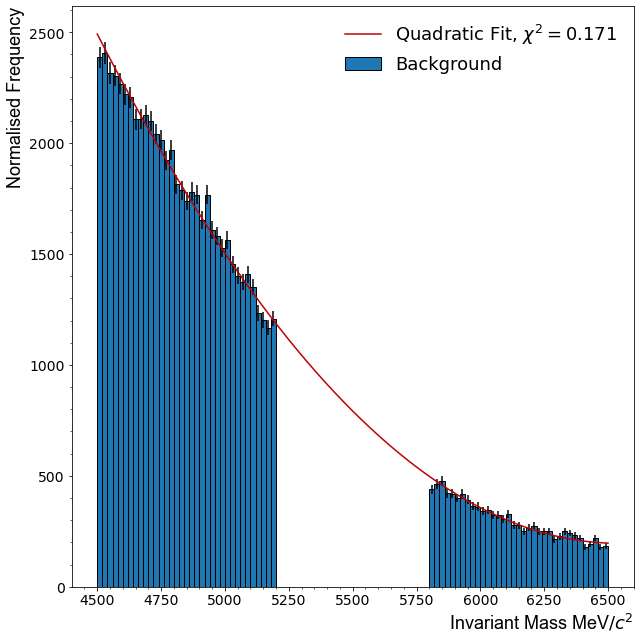

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Background', edgecolor='k')
ax.plot(func_x, quadratic(func_x, *popt), label=r'Quadratic Fit, $\chi^2=0.171$', color='#bf0000')
plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
#plt.savefig('../images/BackgroundFits/BgMassDistributionWithFit_PresentReady.png', dpi=800)
plt.show()

# Goodness of Fit Tests

In [14]:
from scipy.stats import chi2
from scipy.stats import ks_2samp

In [15]:
pred = quadratic(d[:,0], *popt)
chi = np.sum(((d[:,1] - pred)/d[:,2]**2)**2)
chi

0.1711834489289221

We expect chi2 to be distributed according to a chi-square distribution with $\nu=N-p$ d.o.f. I.e. see table in Inference notes that says for $\alpha=0.1$ these values of S should only be exceeded with probability 0.1 if the model is indeed correct.

In [16]:
chi2.ppf(0.05, df=len(pred)-3)

49.16227017917681

In [17]:
ks, kspvalue = ks_2samp(d[:,1], pred)
ks, kspvalue

(0.05714285714285714, 0.9998859703191283)

Very high p-value and small statistic for the KS tests informs us that we cannot reject the null hypothesis. I.e. the two distributions are identical with a 99.99% confidence.